## Music Store Analysis

Writing complex SQL queries to extract relevant, and then creating plots where necessary to visualize the data.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(query):
    conn = sqlite3.connect('chinook.db')
    query = query
    return pd.read_sql(query,conn)
    conn.close()

In [3]:
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        command = command
        conn.isolation_level = None
    conn.execute(command)
    conn.close()

In [4]:
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view')"
    return run_query(q)

In [5]:
print(show_tables())

                    name   type
0                  album  table
1                 artist  table
2               customer  table
3               employee  table
4                  genre  table
5                invoice  table
6           invoice_line  table
7             media_type  table
8               playlist  table
9         playlist_track  table
10                 track  table
11  countries_cust_count   view


## Best-selling Genres in US

In [6]:
query = """
WITH tracks_genres AS
    (
    SELECT
        t.track_id trackid,
        g.name genre
    FROM track t
    LEFT JOIN genre g ON t.genre_id = g.genre_id
    ),
US_tracks AS
    (
    SELECT 
        il.track_id trackid
    FROM invoice_line il
    LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
    LEFT JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )
SELECT 
    tg.genre,
    COUNT(ust.trackid) number_of_tracks,
    (COUNT(ust.trackid)*100 /(SELECT COUNT(*) FROM US_tracks ust)) percentage
FROM US_tracks ust
LEFT JOIN tracks_genres tg ON ust.trackid = tg.trackid
GROUP BY 1
ORDER BY 3 DESC;
"""

print(run_query(query))

                 genre  number_of_tracks  percentage
0                 Rock               561          53
1   Alternative & Punk               130          12
2                Metal               124          11
3             R&B/Soul                53           5
4          Alternative                35           3
5                Blues                36           3
6                Latin                22           2
7                  Pop                22           2
8       Easy Listening                13           1
9          Hip Hop/Rap                20           1
10                Jazz                14           1
11           Classical                 4           0
12   Electronica/Dance                 5           0
13         Heavy Metal                 3           0
14              Reggae                 6           0
15          Soundtrack                 2           0
16            TV Shows                 1           0


In [7]:
genre_sales_usa = run_query(query)

In [8]:
genre_sales_usa.set_index('genre')

,number_of_tracks,percentage
genre,,
Rock,561,53
Alternative & Punk,130,12
Metal,124,11
R&B/Soul,53,5
Alternative,35,3
Blues,36,3
Latin,22,2
Pop,22,2
Easy Listening,13,1


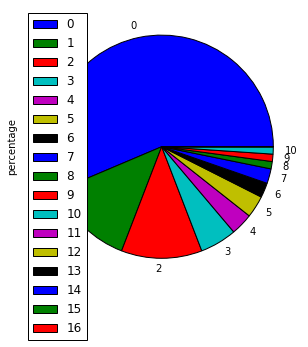

In [9]:
genre_sales_usa.plot.pie(y='percentage', figsize=(5, 5))

## Customer Support Agent Sales

In [10]:
query = """
WITH reps_total AS
    (
    SELECT 
        c.support_rep_id rep_id,
        SUM(i.total) total_sales
    FROM invoice i
    LEFT JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1
    )
SELECT 
    e1.first_name||" "||e1.last_name employee_name,
    e2.first_name||" "||e2.last_name supervisor_name,
    e2.title supervisor_title,
    e1.country,
    rt.total_sales
FROM reps_total rt
LEFT JOIN employee e1 ON rt.rep_id = e1.employee_id
LEFT JOIN employee e2 ON e1.reports_to = e2.employee_id
ORDER BY 5 DESC;
"""

print(run_query(query))

   employee_name supervisor_name supervisor_title country  total_sales
0   Jane Peacock   Nancy Edwards    Sales Manager  Canada      1731.51
1  Margaret Park   Nancy Edwards    Sales Manager  Canada      1584.00
2  Steve Johnson   Nancy Edwards    Sales Manager  Canada      1393.92


In [11]:
sales_per_agent = run_query(query)

In [12]:
sales_per_agent.set_index('employee_name')

,supervisor_name,supervisor_title,country,total_sales
employee_name,,,,
Jane Peacock,Nancy Edwards,Sales Manager,Canada,1731.51
Margaret Park,Nancy Edwards,Sales Manager,Canada,1584.00
Steve Johnson,Nancy Edwards,Sales Manager,Canada,1393.92


Double-checking that there are only 3 support agents:

In [13]:
query = "SELECT COUNT (DISTINCT support_rep_id) FROM customer;"
print(run_query(query))

   COUNT (DISTINCT support_rep_id)
0                                3


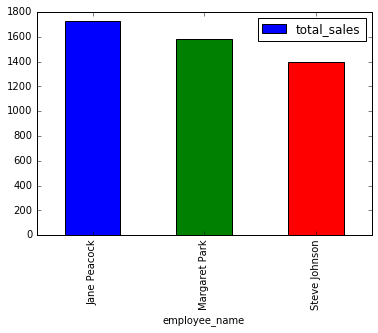

In [14]:
sales_per_agent.plot.bar(x='employee_name', y='total_sales', rot=90)

## Country Stats

In [15]:
c = '''
CREATE VIEW countries_cust_count AS
    SELECT
        country,
        COUNT(DISTINCT customer_id) count
    FROM customer
    GROUP BY 1
    ORDER BY 2 DESC;'''
run_command(c)

OperationalError: table countries_cust_count already exists

In [26]:
q = """
SELECT
    ccc2.country_2 country,
    COUNT(DISTINCT c.customer_id) num_of_customers,
    SUM(i.total)/COUNT(DISTINCT c.customer_id) avg_sales_per_customer,
    SUM(i.total)/COUNT(DISTINCT i.invoice_id) avg_order_value
FROM invoice i
LEFT JOIN customer c ON i.customer_id = c.customer_id
LEFT JOIN (
    SELECT
    *,
    CASE
        WHEN ccc.count = 1 THEN "Other"
        ELSE ccc.country
    END AS country_2        
    FROM countries_cust_count ccc)ccc2 ON ccc2.country = c.country
GROUP BY 1
ORDER BY 2 ASC"""

run_query(q)

,country,num_of_customers,avg_sales_per_customer,avg_order_value
0,Czech Republic,2,136.620000,9.108000
1,India,2,91.575000,8.721429
2,Portugal,2,92.565000,6.383793
3,United Kingdom,3,81.840000,8.768571
4,Germany,4,83.655000,8.161463
5,Brazil,5,85.536000,7.011148
6,France,5,77.814000,7.781400
7,Canada,8,66.948750,7.047237
8,USA,13,80.037692,7.942672
9,Other,15,72.996000,7.448571
